# Classification de décisions de justice

Le notebook ci-joint décrit mon approche du problème de classification des décisions de justice. Je l'ai découpé en plusieurs parties :

1. Chargement des données
2. Feature engeneering
3. Classifieur SVM et sélection de modèle
4. Idées pour aller plus loin

Le principal enjeu sur ce jeu de données proviens des classes CRIM et COM relativement plus difficile à distinguer des classes CIV et SOC. COM est la classe la plus difficile à distinguer de CIV qui est largement sur-représentée. J'ai partiellement corrigé ce biais en ajoutant beaucoup de features propres à ces deux classes.

## 1. Chargement des données

Pour la création de la base MongoDB voir le script "create-decisions-db.py". La base fait à peine plus de 230 mo, i.e. on peut travailler avec les données directement dans la mémoire python. J'imagine que lorsqu'il s'agit de travailler sur le volume total des données de vrais problèmes d'architecture se posent. Vu la nature du problème un cluster Hadoop avec Spark MLLib (qui implémente les SVM) serait probablement une solution appropriée pour bénéficier du traitement paralèlle sur de très gros corpus.

In [1]:
import utils.mongo as um

db = um._connect_mongo('decisions', config['host'], config['port'], config['username'], config['password'])
corpus = um.read_mongo(db, 'decisions', pandas = True)

Le jeu d'entrainement comprend 4 classes de documents (droit civil, commercial, criminel, social). Les classes civil et social sont largement surreprésentées. Un classifieur misant à tous les coups sur le droit civil aurait une précision de 47%.

civ     0.467426
soc     0.437960
com     0.080899
crim    0.013715
Name: class, dtype: float64


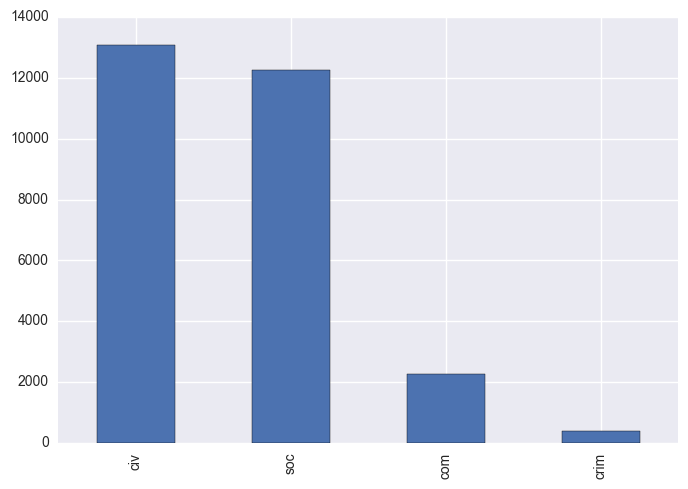

In [2]:
%matplotlib inline
import seaborn
print corpus['class'].value_counts() / corpus['class'].value_counts().sum()
corpus['class'].value_counts().plot('bar')

In [3]:
import random
subsample = random.sample(corpus.index, 15000)
minibatch = corpus.loc[subsample]

## 2. Feature Engeneering

Les documents sont au format HTML, en première approche on considère que les balises HTML contiennent peu d'information sur la classe du document et on se focalise sur le contenu textuel. La première étape consiste donc à coder un transformer "DecisionExtractor" pour tirer ce contenu correctement. 

Après un premier modèle je me suis vite aperçu que le principal enjeu à relever pour optimiser les performances est de bien séparer les décisions criminelles des décisions civiles. Je commence donc par me focaliser sur ce corpus en extrayant un grand nombre de features spécifiques à cette classe :

- Sélection des 300 ngrams les plus fréquents dans le corpus criminel, $n\in [1;3]$
- Calcul de la matrice TF IDF

Ces features sont ajoutés à ceux extraits du corpus total.

In [4]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nltk.corpus import stopwords

from bs4 import BeautifulSoup

class DecisionExtractor(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, corpus):
        return [BeautifulSoup(doc, 'lxml').text for doc in corpus.values]

crim_params = {
    'ngram_range' : (1,3),
    'stop_words' : stopwords.words('french') + ['les'],
    "lowercase" : True,
    'max_features' : 400
}

crim = corpus.loc[corpus['class'] == 'crim']
pipeline_crim = Pipeline([
        ('extract_decisions', DecisionExtractor()),
        ('vectorizer', CountVectorizer(**crim_params))
    ])

pipeline_crim.fit_transform(crim.text)
crim_vocab = pipeline_crim.steps[1][1].get_feature_names()

In [5]:
com_params = {
    'ngram_range' : (1,3),
    'stop_words' : stopwords.words('french') + ['les'],
    "lowercase" : True,
    'max_features' : 800
}

com = corpus.loc[corpus['class'] == 'com']
pipeline_com = Pipeline([
        ('extract_decisions', DecisionExtractor()),
        ('vectorizer', CountVectorizer(**com_params))
    ])

pipeline_com.fit_transform(com.text)
com_vocab = pipeline_com.steps[1][1].get_feature_names()

L'étape suivante consiste à extraire du corpus les ngrams les plus fréquents, à ajouter les features précédents et à calculer les matrices TF-IDF :

- Extraction du texte depuis le corps HTML
- Passage en lower_case
- Filtrage des stopwords
- Features : sélection des 300 ngrams les plus fréquents dans le corpus, $n\in [1;3]$
- Union des matrices TF-IDF calculées

In [6]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

counts_params = {
    'ngram_range' : (1,3),
    'stop_words' : stopwords.words('french') + ['les'],
    "lowercase" : True,
    'max_features' : 300
}

pipeline = Pipeline([
        ('extract_decisions', DecisionExtractor()),
        ('features', FeatureUnion([
                    ('corpus_tfidf', Pipeline([
                                ('counts', CountVectorizer(**counts_params)),
                                ('tf_idf', TfidfTransformer())
                            ])),
                    ('crim_tfidf', Pipeline([
                                ('counts', CountVectorizer(vocabulary=crim_vocab, **counts_params)),
                                ('tf_idf', TfidfTransformer())
                            ])),
                    ('com_tfidf', Pipeline([
                                ('counts', CountVectorizer(vocabulary=com_vocab, **counts_params)),
                                ('tf_idf', TfidfTransformer())
                            ]))
                ]))
    ])

X = pipeline.fit_transform(corpus.text)
y = corpus['class'].values

from sklearn.externals import joblib
joblib.dump([X, y], 'matrices.pkl')

['matrices.pkl']

## 3. Classifieur SVM et sélection de modèle

Suite à une consultation rapide de la littérature, je me suis lancé dans un modèle SVM. Ces modèles ont la réputation de performer correctement pour la classification de texte :

- Ils sont robuste à l'utilisation d'un grand nombre de features : je sélectionne $m = 600$ features dans l'étape précédente, pour un corpus de $n=27998$ documents. D'après la littérature, l'ajout de features est un bon moyen d'augemnter la performance des algos de classification de texte; leur multiplication n'entraine pas spécialement de sur-apprentissage.

- La plupart des problèmes de classification de texte sont linéairement séparables (même si ici ce n'est pas exactement le cas, on sépare mieux l'espace avec un noyau RBF).

- Les modèles SVM fonctionnent bien avec des matrices de features sparse, ce qui est important pour nous d'un point de vu computationnel.


### 3.1 Création des jeux de test et d'entrainement

Je prend 70% des données pour l'entrainement, 30% pour le test.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3.2 Grid Search

Il nous reste à déterminer les hyperparamètres optimaux pour la constante $C$ (contrôle sur la largeur de la marge) et le noyau (linéaire, polynomial ou RBF). L'approche la plus simple (et la plus brutale) consiste simplement à lancer un gridsearch grossier pour se faire une meilleure idée des valeurs à retenir. Pour ne pas perdre de temps, je réalise ce travail sur un minibatch avec une 5-fold cross-validation pour un faible nombre de valeurs ($3\times3\times5 = 45$ taches d'entrainement).

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

param_grid = [
    {'C' : [10, 10**3, 10**6], 'kernel' : ['linear', 'poly', 'rbf']}
]

svm = SVC(verbose = True)

grid_search = GridSearchCV(svm, param_grid, cv=5, verbose = 10)
grid_search.fit(X_train, y_train)
print 'best params : ' + str(grid_search.best_params_)

On utilise donc la meilleure combinaison d'hyper paramètres pour définir le modèle SVM :

In [8]:
from sklearn.svm import SVC
svm = SVC(C=1000, gamma='auto', kernel='rbf', verbose=True)

### 3.3. Cross Validation

Maintenant que j'ai trouvé des hyperparamètres relativement satisfaisants, je lance une validation croisée sur le jeu d'entrainement pour m'assurer de la stabilité des résultats lorsque l'on répète l'entrainement avec des jeu de test / validation différents.

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(svm, X_train, y_train, cv = 3)

import pandas as pd
from sklearn.metrics import confusion_matrix

labels = ['civ', 'crim', 'soc', 'com']
confusion_mat = confusion_matrix(y_train, y_train_pred, labels = labels)
confusion = pd.DataFrame(confusion_mat, index = labels, columns = labels)
confusion['total'] = confusion.sum(axis = 1)
print confusion

from sklearn.metrics import precision_score, recall_score, f1_score
print 'precision moyenne :' + str(precision_score(y_train, y_train_pred, average='weighted'))
print ( confusion / confusion.sum(axis=0))
print 'rappel moyen :' + str(recall_score(y_train, y_train_pred, average='weighted'))
print ( confusion.T / confusion.total).T
print 'f1 score : ' + str(f1_score(y_train, y_train_pred, average='weighted'))

[LibSVM][LibSVM][LibSVM]       civ  crim   soc   com  total
civ   8804     3    57   270   9134
crim     4   255     1     2    262
soc     76     1  8517     1   8595
com    423     1     9  1174   1607
precision moyenne :0.955660727233
           civ      crim       soc       com     total
civ   0.945955  0.011538  0.006640  0.186593  0.466068
crim  0.000430  0.980769  0.000116  0.001382  0.013369
soc   0.008166  0.003846  0.992195  0.000691  0.438565
com   0.045450  0.003846  0.001048  0.811334  0.081998
rappel moyen :0.9567302786
           civ      crim       soc       com  total
civ   0.963871  0.000328  0.006240  0.029560    1.0
crim  0.015267  0.973282  0.003817  0.007634    1.0
soc   0.008842  0.000116  0.990925  0.000116    1.0
com   0.263223  0.000622  0.005600  0.730554    1.0
f1 score : 0.955982452742


La précision moyenne obtenue est de 95.56%, le rappel moyen de 95.67%. Les classes CIV, CRIM et SOC obtiennent toutes les trois une précision supérieure à 94% et un rappel supérieur à 96%. Par contre, les résultats sont moins bons pour la classe COM : la précision est de 81%, le rappel de 73%. Le modèle a globalement du mal à séparer les élements de cette classe de ceux de la classe CIV. Cette classe est pourtant celle sur laquelle j'ai concentré mes efforts (800 features vs 400 pour la classe CRIM, elle aussi sous représentée dans l'échantillon). Avec un peu de feature engeneering supplémentaire, je pense qu'il serait possible de raffiner un peu plus ces performances (qui sont déjà bien plus satisfaisantes que sur mes premiers essais). 

### 3.4. Performance du modèle sur le jeu de test

Dernière étape, j'évalue les résultats du modèle sur le jeu de test.

In [10]:
svm.fit(X_train, y_train)
y_test_pred = svm.predict(X_test)

labels = ['civ', 'crim', 'soc', 'com']
confusion_mat = confusion_matrix(y_test, y_test_pred, labels = labels)
confusion = pd.DataFrame(confusion_mat, index = labels, columns = labels)
confusion['total'] = confusion.sum(axis = 1)
print confusion

from sklearn.metrics import precision_score, recall_score, f1_score
print 'precision moyenne :' + str(precision_score(y_test, y_test_pred, average='weighted'))
print ( confusion / confusion.sum(axis=0))
print 'rappel moyen :' + str(recall_score(y_test, y_test_pred, average='weighted'))
print ( confusion.T / confusion.total).T
print 'f1 score : ' + str(f1_score(y_test, y_test_pred, average='weighted'))

[LibSVM]       civ  crim   soc  com  total
civ   3817     2    25  109   3953
crim     3   119     0    0    122
soc     19     0  3644    4   3667
com    150     0     4  504    658
precision moyenne :0.961675499813
           civ      crim       soc       com     total
civ   0.956881  0.016529  0.006806  0.176661  0.470595
crim  0.000752  0.983471  0.000000  0.000000  0.014524
soc   0.004763  0.000000  0.992105  0.006483  0.436548
com   0.037603  0.000000  0.001089  0.816856  0.078333
rappel moyen :0.962380952381
           civ      crim       soc       com  total
civ   0.965596  0.000506  0.006324  0.027574    1.0
crim  0.024590  0.975410  0.000000  0.000000    1.0
soc   0.005181  0.000000  0.993728  0.001091    1.0
com   0.227964  0.000000  0.006079  0.765957    1.0
f1 score : 0.961954295846


Ces résultats sur le jeu de test sont en accord avec les performances cross-validées sur le jeu d'entrainement. Elles sont même légèrement supérieures, ce qui peut faire penser qu'il y a quelques outliers dans le jeu d'entrainement (ou bien que l'on a eu de la "chance" sur le tirage initial en tirant relativement moins de documets COM que dans le jeu d'entrainement).

## 4. Idées pour aller plus loin

La performance affichée de ce SVM est assez satisfaisante, faire mieux demandera beaucoup de travail pour des gains marginaux. La principale limite de cette approche est le passage à l'échelle sur de très gros corpus, puisque pour $n$ documents et $m$ features l'entrainement des SVM ont une complexité en $O(n^2 \times m)$. Le passage à une architecture distribuée et à une implémentation sous Spark MLLib est une solution intéressante face à ce problème.

Quelques idées pour raffiner l'approche :

- Ajouter des features pour améliorer la performance sur la classe COM.
- Optimiser plus finement les hyperparamètres en lançant un GridSearch plus large.
- Tester la performance d'autres modèles (réseaux de neurones).